Here are 2 links for the brain tumors mat files + (label for clasification) [1],  and ground thruth mat files.[2]

[1][Images of tumors](https://drive.google.com/file/d/1QwZIFdMsfYa_KMRMWfIG5znmrRumhDXw/view?usp=sharing)
[2][Labels for segmentation](https://drive.google.com/file/d/1M-V3a72oQDR9b52FvTTEepSprYHYpOCf/view?usp=sharing)


In [0]:
#Then you upload the files you already download to your drive
#Connect to your google drive

from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
#RUN
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF

import torchvision.datasets as dsets
from skimage import transform
import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable
import pandas as pd;
import numpy as np;
from torch.utils.data import Dataset, DataLoader
#from vis_utils import *
import random;
import math;
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
from torchvision import models
from torch.optim import lr_scheduler
#from tensorboard_logger import configure, log_value
import time

In [0]:
#Read the images and ground_truth from drive

#RUN
Fold_1 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_1.mat')
Fold_2 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_2.mat')
Fold_3 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_3.mat')
Fold_4 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_4.mat')
Fold_5 = sio.loadmat('/content/gdrive/My Drive/Licenta/Fold_5.mat')

fold_1 = Fold_1['Fold_1']
fold_2 = Fold_2['Fold_2']
fold_3 = Fold_3['Fold_3']
fold_4 = Fold_4['Fold_4']
fold_5 = Fold_5['Fold_5']


In [0]:
def get_5_fold(index_4, index_1):
    x = [None]*5
    y = [None]*5
    t = [None]*5
    x[0] = fold_1[:,0]
    x[1] = fold_2[:,0]
    x[2] = fold_3[:,0]
    x[3] = fold_4[:,0]
    x[4] = fold_5[:,0]

    y[0] = fold_1[:,1:(512*512)+ 1]
    y[1] = fold_2[:,1:(512*512)+ 1]
    y[2] = fold_3[:,1:(512*512)+ 1]
    y[3] = fold_4[:,1:(512*512)+ 1]
    y[4] = fold_5[:,1:(512*512)+ 1]

    t[0] = fold_1[:,(512*512)+ 1:2*(512*512)+ 1]
    t[1] = fold_2[:,(512*512)+ 1:2*(512*512)+ 1]
    t[2] = fold_3[:,(512*512)+ 1:2*(512*512)+ 1]
    t[3] = fold_4[:,(512*512)+ 1:2*(512*512)+ 1]
    t[4] = fold_5[:,(512*512)+ 1:2*(512*512)+ 1]

    labels_train = np.concatenate([x[index_4[0]], x[index_4[1]], x[index_4[2]], x[index_4[3]]], 0)
    images_train = np.concatenate([y[index_4[0]], y[index_4[1]], y[index_4[2]], y[index_4[3]]], 0)
    masks_train = np.concatenate([t[index_4[0]], t[index_4[1]], t[index_4[2]], t[index_4[3]]], 0)

    labels_test = x[index_1[0]]
    images_test = y[index_1[0]]
    masks_test = t[index_1[0]]
    del x,y,t
    return labels_train, images_train, masks_train, labels_test, images_test, masks_test

In [0]:
# Realize 5-fold cross-validation
from itertools import combinations 
  
# Get all combinations of [1, 2, 3, 4, 5] 
# and length 4
comb = combinations([0, 1, 2, 3, 4], 4) 
comb = list(comb)
#Choose a combination from 0..4
ind = 0
res = [ele  for ele in range(5) if ele   not in comb[ind]] 

#Print first 4-fold indexex for train, and 1-fold index for test
print('Indexes for train: ', comb[ind])
print('Index for test', res)

labels_train, images_train, masks_train, labels_test, images_test, masks_test = get_5_fold(comb[ind], res)
#depend on batch_size


Indexes for train:  (0, 1, 2, 3)
Index for test [4]


In [0]:
#RUN
# Choose l1 and l2 depending on batch_size, and 5_fold generation
# batch should divide de size
# Here I hard coded the values for train and test, depending on folders that I have selected for train and test
l = [[2400, 630], [2430, 600], [2460, 570], [2370, 630], [2490, 540]]

size_train_loader = l[ind][0]
size_test_loader = l[ind][1]

labels_train = labels_train[0:size_train_loader]
images_train = images_train[0:size_train_loader, :]
masks_train = masks_train[0:size_train_loader, :]

labels_test = labels_test[0:size_test_loader]
images_test = images_test[0:size_test_loader, :]
masks_test = masks_test[0:size_test_loader, :]

print(labels_train.shape, images_train.shape, masks_train.shape)
print(labels_test.shape, images_test.shape, masks_test.shape)



(2400,) (2400, 262144) (2400, 262144)
(630,) (630, 262144) (630, 262144)


In [0]:
#RUN to permute data
from sklearn.utils import shuffle

shuffle_labels_train, shuffle_images_train, shuffle_mask_train = shuffle(labels_train, images_train, masks_train, random_state=0)
shuffle_labels_test, shuffle_images_test, shuffle_mask_test = shuffle(labels_test, images_test, masks_test, random_state=0)



In [0]:
#free RAM, because session will crash
%reset_selective -f Fold_1
%reset_selective -f Fold_2
%reset_selective -f Fold_3
%reset_selective -f Fold_4
%reset_selective -f Fold_5

%reset_selective -f fold_1
%reset_selective -f fold_2
%reset_selective -f fold_3
%reset_selective -f fold_4
%reset_selective -f fold_5



In [0]:
shuffle_labels_train = torch.from_numpy(shuffle_labels_train)
shuffle_images_train = torch.from_numpy(shuffle_images_train)
shuffle_mask_train = torch.from_numpy(shuffle_mask_train)

shuffle_labels_test = torch.from_numpy(shuffle_labels_test)
shuffle_images_test = torch.from_numpy(shuffle_images_test)
shuffle_mask_test = torch.from_numpy(shuffle_mask_test)

In [0]:
#Compute mean and std 
mean_tr = (shuffle_images_train.float().mean())
std_tr = (shuffle_images_train.float().std())
print(mean_tr, std_tr)

tensor(457.7594) tensor(644.9455)


In [0]:
#Dataset return brain image, gt of segmentation
class BrainDataset(Dataset):
    '''Brain Dataset'''
    def __init__(self, t_x, t_y, ratio, size, transform=None):
        self.X = t_x
        self.Y = t_y
        self.ratio = ratio
        self.size = size
        self.transform = transform
    def __len__(self):
        return len(self.X);
      
    def transformm(self, image, mask):

        # Random horizontal flipping
        image = transforms.ToPILImage()(image)
        mask = transforms.ToPILImage()(mask)
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
            
        if random.random() > 0.5:
            rotation = random.randint(15, 45)
            image = TF.rotate(image, rotation)
            mask = TF.rotate(mask, rotation)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask

    
    def __getitem__(self, idx):
        item = self.X[idx];
        label = self.Y[idx];
        
        #imaginea 512x512 o transform in size x size
        #image 512x512 will become 512/ratio x 512//ratio for optimize memory
        
        item = item.view(-1, 512)
        item = item[0:512:self.ratio,0:512:self.ratio]
                
        label = label.view(-1, 512)
        label = label[0:512:self.ratio,0:512:self.ratio]
        
        item = item.float()
        item = (item - mean_tr)/std_tr
        
        if self.transform == 1:   
          item, label = self.transformm(np.float32(item.view(-1, self.size)), np.float32(label.view(-1, self.size)))
        else:
          label = transforms.ToPILImage()(np.float32(label.view(-1, self.size)))
          item = transforms.ToPILImage()(np.float32(item.view(-1, self.size)))
          label = TF.to_tensor(label)
          item = TF.to_tensor(item)
        return (item, label)

In [0]:
#Dataset return brain image, gt of segmentation and label of tumor
class BrainDatasetL(Dataset):
    '''Brain Dataset'''
    def __init__(self, t_x, t_y, t_z, ratio, size, transform=None):
        self.X = t_x
        self.Y = t_y
        self.Z = t_z
        self.ratio = ratio
        self.size = size
        self.transform = transform
    def __len__(self):
        return len(self.X);
      
    def transformm(self, image, mask):

        # Random horizontal flipping
        image = transforms.ToPILImage()(image)
        mask = transforms.ToPILImage()(mask)
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
            
        if random.random() > 0.5:
            rotation = random.randint(15, 45)
            image = TF.rotate(image, rotation)
            mask = TF.rotate(mask, rotation)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask

    
    def __getitem__(self, idx):
        item = self.X[idx];
        label = self.Y[idx];
        nr = self.Z[idx]
        
        #imaginea 512x512 o transform in size x size
        #image 512x512 will become 512/ratio x 512//ratio for optimize memory
        
        item = item.view(-1, 512)
        item = item[0:512:self.ratio,0:512:self.ratio]
                
        label = label.view(-1, 512)
        label = label[0:512:self.ratio,0:512:self.ratio]
        
        item = item.float()
        item = (item - mean_tr)/std_tr
        
        if self.transform == 1:   
          item, label = self.transformm(np.float32(item.view(-1, self.size)), np.float32(label.view(-1, self.size)))
        else:
          label = transforms.ToPILImage()(np.float32(label.view(-1, self.size)))
          item = transforms.ToPILImage()(np.float32(item.view(-1, self.size)))
          label = TF.to_tensor(label)
          item = TF.to_tensor(item)
        return (item, label, nr)

In [0]:
batch_size = 30
ratio = 2 #how much we reduce from 1 dimension of image. Ex. ratio = 2 => 256x256 image , ratio = 4 => 512x512
size_image = 256 #Dimmension by dividing height and weight to ratio

train_dataset = BrainDataset(shuffle_images_train, shuffle_mask_train, ratio, size_image, transform = 1)

test_dataset = BrainDataset(shuffle_images_test,shuffle_mask_test, ratio, size_image, transform = 0)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                   );
train_set = BrainDataset(shuffle_images_train, shuffle_mask_train, ratio, size_image, transform = 0)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          );
trtest_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=1,
                                          );


##########
datasett  = BrainDatasetL(shuffle_images_test,shuffle_mask_test, shuffle_labels_test, ratio, size_image, transform = 0)

test_all =  torch.utils.data.DataLoader(dataset=datasett,
                                          batch_size=1,
                                          );




torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
tensor(3, dtype=torch.int16)


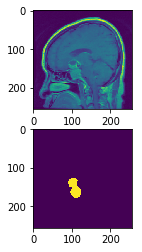

630


In [0]:
#Test if data is normalized, and mask is correlated with image
#Print values from an image to see if values are normalized

t, l, n = datasett.__getitem__(0)
#print(t[0][100])
print(t.shape)
print(l.shape)
print(n)

plt.figure(1)
plt.subplot(211)
plt.imshow(t[0])

plt.subplot(212)
plt.imshow(l[0])
plt.show()
print(test_dataset.__len__())

In [0]:
#Network arhitechture

import torch.nn as nn
from torchvision import models

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet101(pretrained=True)
        
        self.base_layers = list(self.base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.functional.interpolate
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4, scale_factor=2, mode='bilinear', align_corners=True)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x, scale_factor=2, mode='bilinear', align_corners=True)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x, scale_factor=2, mode='bilinear', align_corners=True)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x, scale_factor=2, mode='bilinear', align_corners=True)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x,scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)        
        
        return out  

class ResNetUNetWithout1x1(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        self.base_layers = list(self.base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        
        self.upsample = nn.functional.interpolate
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        x = self.upsample(layer4, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x,scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)        
        
        return out

## Loss function

In [0]:
#Doesnt work
class SoftBootstrappingLoss(nn.Module):
    """
    Loss(t, p) = - (beta * t + (1 - beta) * p) * log(p)
    """
    def __init__(self, beta=0.9, reduce=True):
        super(SoftBootstrappingLoss, self).__init__()
        self.beta = beta
        self.reduce = reduce

    def forward(self, input, target):
        target = target.long()
        target = target.view(-1, size_image, size_image)
        # cross_entropy = - t * log(p)
        beta_xentropy = self.beta * F.cross_entropy(input, target, reduce=False)

        # second term = - (1 - beta) * p * log(p)
        bootstrap = - (1.0 - self.beta) * torch.sum(F.softmax(input, dim=1) * F.log_softmax(input, dim=1), dim=1)

        if self.reduce:
            return torch.mean(beta_xentropy + bootstrap)
        return beta_xentropy + bootstrap
criterion = SoftBootstrappingLoss()
criterion = nn.BCEWithLogitsLoss()

In [0]:
import torch.nn.functional as F

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()
  
def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)
    #loss = criterion(pred, target)
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

## Training

In [0]:
from collections import defaultdict
import copy
import time
import os


def train_model(model, best_loss, optimizer, scheduler, dataloaders, save_path, num_epochs=25, print_mini_batch_loss=False):
    best_model_wts = copy.deepcopy(model.state_dict())
    if not os.path.exists(save_path):
        os.makedirs(save_path[0: save_path.rfind('/')], exist_ok=True)

    epoch_losses = {
        'train': [],
        'val': []
    }
    epoch_metrics = {
        'IOU': [],
        'Dice': []
    }
    epoch_loss = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()
        acc = 0
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step(epoch_loss)
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                
                data = inputs.expand(-1, 3, -1, -1)
                data = data.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(data)
                    #labels = labels.long()
                    #labels = labels.view(-1, 256, 256)
                    loss = calc_loss(outputs, labels, metrics)
                    if print_mini_batch_loss:
                        print("Mini batch loss: " + str(loss))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            epoch_bce = metrics['bce'] / epoch_samples
            epoch_dice = metrics['dice'] / epoch_samples
            epoch_losses[phase].append({'loss': epoch_loss, 'bce': epoch_bce, 'dice': epoch_dice})
           
            if phase == 'val':  
                acc = MeanIOU(model, test_loader, size_test_loader)
                dice = MeanDice(model, test_loader, size_test_loader)
                IOU.append(acc)
                Dice.append(dice)
                test_loss.append(epoch_loss)

            else:
                train_loss.append(epoch_loss)
              
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), save_path)
                print('==================')
                print('Accuracy: ', acc)
                print('==================')

                
        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    #with open('/content/gdrive/My Drive/Licenta/resnet_freeze_learning.txt', 'w') as f:
    #   f.write(str(epoch_losses))
    #with open('/content/gdrive/My Drive/Licenta/losses.txt', 'w') as f:
    #   f.write(str(epoch_losses))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_loss

In [0]:
 def T_dice_coefficient(predicted, target):
        """Calculates the Sørensen–Dice Coefficient for a
        single sample.
        Parameters:
            predicted(numpy.ndarray): Predicted single output of the network.
                                    Shape - (Channel,Height,Width)
            target(numpy.ndarray): Actual required single output for the network
                                    Shape - (Channel,Height,Width)
        Returns:
            coefficient(float): Dice coefficient for the input sample.
                                        1 represents high similarity and
                                        0 represents low similarity.
        """
        smooth = 1
        #predicted = predicted.cpu().numpy()
        #target = target.cpu().numpy()
        product = np.multiply(predicted, target)
        intersection = np.sum(product)
        coefficient = (2*intersection + smooth) / \
            (np.sum(predicted) + np.sum(target) + smooth)
        return coefficient
#functia de acurate, intersection over union
#Accuracy metric function, IOU intersection over union for DICELOSS
def MeanDice(model, loader, len, tr = 0.5):
    total_score = 0
    model.eval()
    for i, (img, mask_t) in enumerate(loader):
        
        size = img.shape[0]
        if size != 1:
           raise Exception("Set batch size to 1 for testing purpose")
        else:
          
          data = img.expand(-1, 3, -1, -1)
          data = data.to(device).float()
          with torch.no_grad():
             mask_pred = model(data)
         
          mask = mask_t[0][0]
          mask_pred = mask_pred[0][0]

          output = (mask_pred > tr)
          output = output.cpu().numpy()
          output = np.resize(output, (size_image, size_image))
          mask = np.resize(mask,(size_image, size_image))
          iou_score = T_dice_coefficient(output, mask)
          total_score += iou_score
    model.train()
    return total_score/len

In [0]:
#Accuracy metric function, IOU intersection over union for DICELOSS
def MeanIOU(model, loader, len, tr = 0.5):
    total_score = 0
    model.eval()
    for i, (img, mask_t) in enumerate(loader):
       
        size = img.shape[0]
        
        if size != 1:
           raise Exception("Set batch size to 1 for testing purpose")
        else:  
          data = img.expand(-1, 3, -1, -1)
          data = data.to(device).float()
          with torch.no_grad():
             mask_pred = model(data)
         
          mask = mask_t[0][0]
          mask_pred = mask_pred[0][0]
          output = (mask_pred > tr)
          output = output.cpu().numpy()
          output = np.resize(output, (size_image, size_image))
          intersection = np.logical_and(mask, output)
          union = np.logical_or(mask, output)
          iou_score = np.sum(intersection.cpu().detach().numpy()) / np.sum(union.cpu().detach().numpy())
          total_score += iou_score
    model.train()
    return total_score/len

In [0]:
#intersection over union, binary segmenatation 
def dice_cross(model, loader, len):
    total = 0
    for i, (img, mask_t) in enumerate(loader):
        
        data = img.expand(-1, 3, -1, -1)
        data = data.to(device).float()
        sizee = img.shape[0]
        if sizee != 1:
           raise Exception("Set batch size to 1 for testing purpose")
        else:
          with torch.no_grad(): 
            mask_pred = model(data)

        mask = mask_t[0]
        tt = mask_pred[0]
        lbl_pred = tt.max(0)[1].cpu()  
        
        iou_score = T_dice_coefficient(lbl_pred, mask)
        total += iou_score
        
    return total/len

In [0]:
#intersection over union, binary segmenatation 
def iou_cross(model, loader, len):
    total = 0
    to = 0
    for i, (img, mask_t) in enumerate(loader):
        
        data = img.expand(-1, 3, -1, -1)
        data = data.to(device).float()
        sizee = img.shape[0]

        if sizee != 1:
           raise Exception("Set batch size to 1 for testing purpose")
        else:
          with torch.no_grad(): 
            mask_pred = model(data)

        mask = mask_t[0]
        tt = mask_pred[0]
        lbl_pred = tt.max(0)[1].cpu()
        intersection = np.logical_and(mask, lbl_pred)
        union = np.logical_or(mask, lbl_pred)
        iou_score = np.sum(intersection.cpu().detach().numpy()) / np.sum(union.cpu().detach().numpy())
        total += iou_score
        
    return total/len

In [0]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
batch_size = 30
best_loss = 1e10

dataloaders = {
    'train': train_loader,
    'val': test_loader
}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
num_class = 2
model = ResNetUNetWithout1x1(1).to(device)

# freeze backbone layers
#for l in model.base_layers:
#   for param in l.parameters():
#       param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
#exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor=0.85, patience=2, verbose=True)



cuda:0


In [0]:
torch.cuda.empty_cache()
path_load = 'gdrive/My Drive/Licenta/Resnetw1x1_aug/best_model_resnet_without_1x1_freeze_augg.txt'
model.load_state_dict(torch.load(path_load))
#print(MeanIOU(model, trtest_loader, size_train_loader )) #0.59
#print(MeanDice(model, trtest_loader, size_train_loader))
print(MeanIOU(model, test_loader, size_test_loader)) #0.59
print(MeanDice(model, test_loader, size_test_loader, 0.2))

0.6825395553438158
0.7789220308255679


In [0]:
#List to save losses during training and testing
train_loss = []
test_loss = []
IOU = []
Dice = []

In [0]:
lr = 0.00001
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.75)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor=0.75, patience=10, verbose=True)

print(optimizer_ft)


In [0]:
#Train
model, loss = train_model(model, best_loss, optimizer_ft, scheduler, dataloaders, '/content/gdrive/My Drive/Licenta/Resnetw1x1_aug/best_model_resnet1x1_aug.txt', num_epochs=10, print_mini_batch_loss=False)
best_loss = loss

In [0]:
#Use this only with resnet model, and after you trained some epochs
ct = 0
for child in model.children():
  ct += 1
  if ct > 0: #>5 defreeze 1 layer from backbone, >4 2 layers
    for param in child.parameters():
        param.requires_grad = True
  print(child)
print(ct)

for name, child in model.named_children():
  for name_2, params in child.named_parameters():
    print(name_2, params.requires_grad)
  print('-----------------------')

In [0]:
from matplotlib import pyplot
def plot_loss(loss, label, name, xlabel, ylabel, color='blue'):
    pyplot.plot(loss, label=label, color=color)
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    pyplot.legend()
    pyplot.savefig(name)

nume = 'Resnet1x1_cross.png'
def plot_loss_t_t(loss1, loss2, label1, label2, name, color1='blue', color2='red'):
    pyplot.plot(loss1, label=label1, color=color1)
    pyplot.plot(loss2, label=label2, color=color2)
    pyplot.xlabel('Epoca')
    pyplot.ylabel('Eroare')
    pyplot.legend()
    pyplot.savefig(name)

In [0]:
plot_loss_t_t(train_loss, test_loss, 'train_loss', 'test_loss', '/content/gdrive/My Drive/Licenta/Resnet1x1_cross/train_test_loss' + nume,'red', 'blue')


In [0]:
plot_loss(IOU,'Mean_IOU', '/content/gdrive/My Drive/Licenta/Resnet1x1_cross/mean_iou' + nume,'Epoca', 'IOU', 'red')

In [0]:
plot_loss(Dice,'Dice_score','/content/gdrive/My Drive/Licenta/Resnet_cross/dice_score' + nume, 'Epoca', 'Scor Dice', 'red')

In [0]:
unique, counts = np.unique(shuffle_labels_train, return_counts=True)
uniquee, countss = np.unique(shuffle_labels_test, return_counts=True)
print(counts, countss)


torch.Size([1, 3, 256, 256]) torch.Size([1, 256, 256]) tensor(3, dtype=torch.int16)
Time: 0.005958s
0.8159675236806495
0.8987341772151899


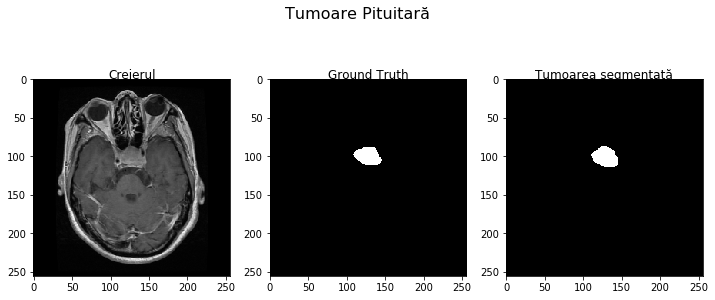

In [0]:
#Evaluate 1 image
#Load pretrained

path_load = 'gdrive/My Drive/Licenta/Resnetw1x1_aug/best_model_resnet_without_1x1_freeze_augg.txt'
model.load_state_dict(torch.load(path_load))
labels_map = {1 : 'Meningiom', 2 : 'Gliom', 3 : 'Tumoare Pituitară'};

t = model.eval()
#Select the index of image from [0, 629]
ind = 250

img1, mask_t, nr = datasett.__getitem__(ind)

img1 = img1.view(-1, 1, 256, 256)
img1 = img1.expand(-1, 3, -1, -1)
print(img1.shape, mask_t.shape, nr)

img1 = img1.to(device).float()
mask_t = mask_t.long()
mask_t = mask_t[0].view(-1, size_image)
tr = 0.0

since = time.time()
with torch.no_grad():
  mask_pred = model(img1)
  
time_elapsed = time.time() - since
print('Time: {:0f}s'.format(time_elapsed))

  
mask = mask_t[0][0]
mask_pred = mask_pred[0][0]
output = (mask_pred > tr)
output = output.cpu().numpy()

index = nr.cpu().numpy()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, )
fig.suptitle(labels_map[index.item()], fontsize=16,  y=0.7)
ax1.imshow(img1[0][0].cpu(), 'gray')
ax1.title.set_text('Creierul')
ax2.imshow(mask_t, 'gray')
ax2.title.set_text('Ground Truth')
ax3.imshow(output, 'gray')
ax3.title.set_text('Tumoarea segmentată')
fig_size = plt.rcParams["figure.figsize"]
 
#Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams['axes.titlepad'] = 0

intersection = np.logical_and(mask_t,output)
union = np.logical_or(mask_t, output)
iou_score = np.sum(intersection.cpu().detach().numpy()) / np.sum(union.cpu().detach().numpy())
dice_score = T_dice_coefficient(output, mask_t.cpu().detach().numpy())


print(iou_score)
print(dice_score)